In [ ]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, pretendl = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if pretend == 'manual':
    manual = True

In [1]:
import geopandas as gpd
import pandas as pd

C:\Users\qchasserieau\AppData\Local\Continuum\anaconda3\envs\quetzal_env\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [3]:
import rasterio
from visualization import add_raster, add_north, add_scalebar, add_north_and_scalebar
raster= rasterio.open(r'../../inputs/tiff/20137.tiff')

In [4]:
growth = pd.read_excel(
    '../../inputs/parameters.xlsx',
    usecols=['category', 'parameter', 'base', 'bipolar', 'scattered', 'polycentric'],
    index_col=[0,1]
).loc['population_growth'].T

# RENAME COLUMNS
urban_shape = pd.read_excel(
    '../../inputs/parameters.xlsx',
    usecols=['category', 'parameter', 'base', 'bipolar', 'scattered', 'polycentric'],
    index_col=[0,1]
).loc['general', 'urban_shape' ].to_dict()
growth = growth.rename(index=urban_shape)
growth

parameter        existing_high existing_low existing_vacant reserved    open  \
2020                         0            0               0        0       0   
Two Cities               98183        40000           72000        0  125417   
Scattered City               0            0           58160        0  337440   
Polycentric City         62000        80000           80000        0  134145   

parameter            nip  
2020                   0  
Two Cities        180000  
Scattered City    120000  
Polycentric City  160000

In [5]:
zones = gpd.read_file('../../inputs/zones/zones_project.geojson')

In [6]:
import string

In [7]:
def format_string(s):
    
    try: 
        s = s.replace('é', 'e').replace(' ', '_')
        return ''.join(i for i in s if i in string.printable)
    except:
        return s

In [8]:
latin_columns = ['latin', 'latin_code', 'latin_name', 'kebele_latin']
zones[latin_columns] = zones[latin_columns].applymap(format_string)

In [9]:
#zones['polycentric'] = zones['polycentric'].fillna(0).astype(bool).astype(int)

In [10]:
zones = zones.to_crs(epsg='20137')

In [11]:
zone_to_type = {
    '3' : 'existing_high',
    '1' : 'nip',
    '4' : 'reserved',
    '2' : 'existing_low',
    '5' : 'open_central',
    '6' : 'open_peripheric',
    '7' : 'existing_vacant'
    
}
type_to_type ={
    'open_central': 'open',
    'open_peripheric': 'open'    
}
zones['type'] = zones['zone'].apply(lambda z: type_to_type.get(zone_to_type[z], zone_to_type[z]))

zones['Two Cities'] = (1 - zones['bipolar'].fillna(0)).astype(int)
zones['Polycentric City'] = (1 - zones['polycentric'].fillna(0).astype(bool).astype(int)).astype(int)
zones['Compact City'] = zones['Polycentric City']
zones['Scattered'] = zones['Two Cities']
zones['Worst Scattered'] = zones['Two Cities']
zones['Scattered City'] = zones['Two Cities']

zones['area'] = zones['geometry'].apply(lambda g: g.area) / 1e6

In [12]:
import numpy as np

In [13]:
zones['max_density'] = zones['type'].apply(lambda t: {'existing_high': 16000}.get(t, 12000))
zones['pop_density'] = (zones['population'] / zones['area'] ).fillna(0)
zones['Population Density 2020'] = zones['pop_density']
zones['Population 2020'] = zones['population']
zones['growth_potential'] = np.clip(zones['max_density'] * zones['area'] - zones['population'].fillna(0), 0, None)

In [14]:
z = zones.copy()
z.loc[(z['growth_potential'] == 0) & (z['Population Density 2020'] == 0)][['type', 'area']]

Empty DataFrame
Columns: [type, area]
Index: []

In [15]:
def grow(zones, growth_series, central_dummy='central', priority=1):
    zones['growth_potential'] = np.clip(zones['max_density'] * zones['area'] - zones['population'].fillna(0), 0, None)
    zones = zones.copy()
    if central_dummy == 'Polycentric City':
        zones.loc[zones['polycentric'] == 2, 'growth_potential'] = 0
    zones['central'] = zones[central_dummy]
    zones['central'] = zones['central'].apply({1: 'central', 0: 'peripheric'}.get)

    df = zones.groupby(['central', 'type'])[['area', 'population', 'growth_potential']].sum()
    potential = df[['growth_potential']].unstack(('central')).fillna(0)
    

    potential['total'] = growth_series
    p = potential.copy()
    
    p[ 'centrality'] = (p['growth_potential','central'] * priority)  \
        /(p['growth_potential','central'] * priority + p['growth_potential','peripheric'])
    p['issue'] =np.clip( p['total'] - p['growth_potential'].sum(axis=1), 0, None)
    p['growth', 'central'] = pd.DataFrame(
        [p['centrality']*p[ 'total'], p['growth_potential','central']]).min()
    p['growth', 'peripheric'] = pd.DataFrame([p['total'] - p['growth', 'central'], p['growth_potential','peripheric']]).min()
    for where in 'central', 'peripheric':
        p['development',where] = (p['growth', where] / p['growth_potential', where]).fillna(0)
    p[['growth_potential', 'growth', 'development', 'total', 'issue']]
    p['growth_potential', 'total'] = p['growth_potential'].sum(axis=1)
    
    big = ['total','issue', 'growth_potential',  'growth']
    percent = [ 'development']
    summary = pd.concat(
        [
            np.round(p[big], -2).astype(int),
            np.round(p[percent]*100).astype(int).astype(str) + '%'
        ],
        axis=1
    )
    dev_dict = p['development'].stack().to_dict()
    z = zones.set_index(['central', 'type'], drop=False)
    zones['development'] = zones.apply(lambda z: dev_dict[(z['type'], z['central'])], axis=1)
    zones['pop_growth'] = zones['development'] * zones['growth_potential']
    zones['pop_growth'].sum()

    zones['population_2040'] = zones['population'].fillna(0) + zones['pop_growth']
    zones['population_density_2040'] = np.round(zones['population_2040'] / zones['area'], -2).astype(int)
    return zones, summary
def prettify(ax):
    add_raster(ax, raster, keep_ax_limits=True)
    add_north(ax)
    add_scalebar(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
def plot_density(
    zones, column='population_density_2040', cmap='YlOrRd', scheme='UserDefined', ax=None, legend=True, 
    bins=[1000,2000, 5000, 10000, 15000, 25000]):
    dummy = zones.iloc[0].copy()
    dummy[column] = 0
    
    #zones = zones.loc[zones[column]>= bins[0]]
    
    cax = None
    if scheme is None:
        fig, ax = plt.subplots(1, 1, figsize=(17, 7))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.05)
        
    ax = zones.append(dummy).plot(
        column=column, figsize=(17, 7), legend=legend, 
        cmap=cmap, scheme=scheme, classification_kwds={'bins': bins}, # scheme='UserDefined',
        alpha=0.67, ax=ax, cax=cax
    )
    prettify(ax)
    try:
        leg = ax.get_legend()
        for t in leg.get_texts():
            t.set_text(t.get_text().replace('.00', ''))
        leg.set_bbox_to_anchor((1, 0.35, 0.0, 0.))
        leg.set_title('Population Density hab / km²')
    except AttributeError:
        pass

    return ax

In [16]:
to_concat = []
keys = []

for scen, priority in [('Polycentric City', 1000000), ( 'Two Cities', 1000000), ('Scattered City', 1)]:
    growth_scenario = growth.loc[scen]
    zones, summary = grow(zones, growth_scenario, scen, priority=priority)
    zones['Population ' + scen] = zones['population_2040'] 
    zones['Population Density ' + scen] = zones['population_density_2040']
    to_concat.append(summary)
    keys.append(scen)
summaries = pd.concat(to_concat, keys=keys)
summaries.index.names = ['scenario', 'type']
summaries.columns.names = ['indicator', 'zone']

In [17]:
summaries

indicator                          total issue growth_potential             \
zone                                                    central peripheric   
scenario         type                                                        
Polycentric City existing_high     62000     0           130000       8700   
                 existing_low      80000     0            52700      27600   
                 existing_vacant   80000     0           132100       5800   
                 nip              160000     0           120700     271600   
                 open             134145     0            36700     178500   
                 reserved              0     0            47000      53100   
Two Cities       existing_high     98183     0           138700          0   
                 existing_low      40000     0            55500      24900   
                 existing_vacant   72000     0           115300      22500   
                 nip              180000     0           225500     267200   
                 open             125417     0           204600     511300   
                 reserved              0     0            65400      34700   
Scattered City   existing_high         0     0           138700          0   
                 existing_low          0     0            55500      24900   
                 existing_vacant   58160     0           115300      22500   
                 nip              120000     0           225500     267200   
                 open             337440     0           204600     511300   
                 reserved              0     0            65400      34700   

indicator                                 growth            development  \
zone                               total central peripheric     central   
scenario         type                                                     
Polycentric City existing_high    138700   62000          0         48%   
                 existing_low      80400   52700      27300        100%   
                 existing_vacant  137900   80000          0         61%   
                 nip              392300  120700      39300        100%   
                 open             215200   36700      97400        100%   
                 reserved         100100       0          0          0%   
Two Cities       existing_high    138700   98200          0         71%   
                 existing_low      80400   40000          0         72%   
                 existing_vacant  137900   72000          0         62%   
                 nip              492600  180000          0         80%   
                 open             715900  125400          0         61%   
                 reserved         100100       0          0          0%   
Scattered City   existing_high    138700       0          0          0%   
                 existing_low      80400       0          0          0%   
                 existing_vacant  137900   48700       9500         42%   
                 nip              492600   54900      65100         24%   
                 open             715900   96400     241000         47%   
                 reserved         100100       0          0          0%   

indicator                                    
zone                             peripheric  
scenario         type                        
Polycentric City existing_high           0%  
                 existing_low           99%  
                 existing_vacant         0%  
                 nip                    14%  
                 open                   55%  
                 reserved                0%  
Two Cities       existing_high           0%  
                 existing_low            0%  
                 existing_vacant         0%  
                 nip                     0%  
                 open                    0%  
                 reserved                0%  
Scattered City   existing_high           0%  
                 existing_low            0%  
   

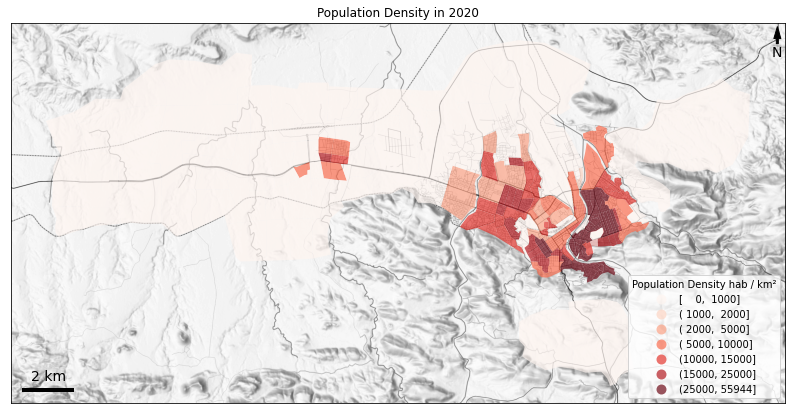

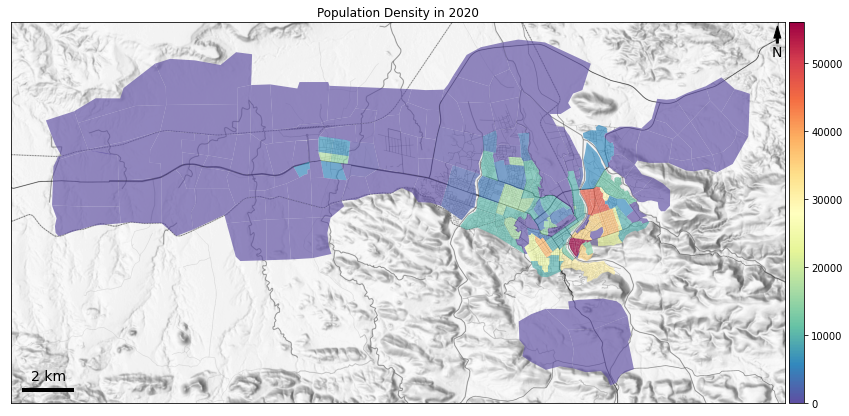

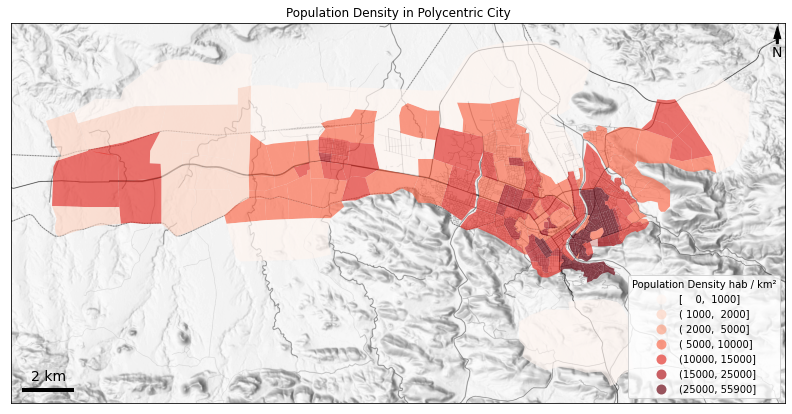

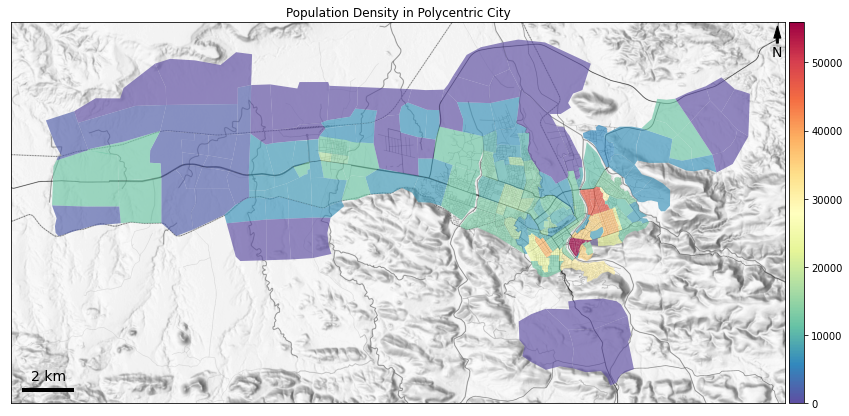

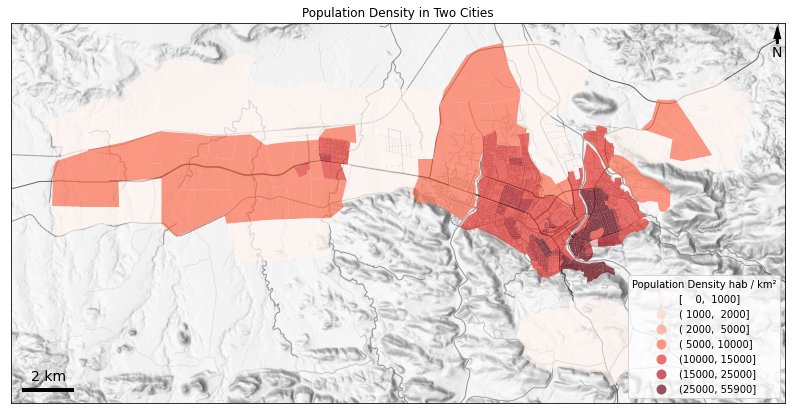

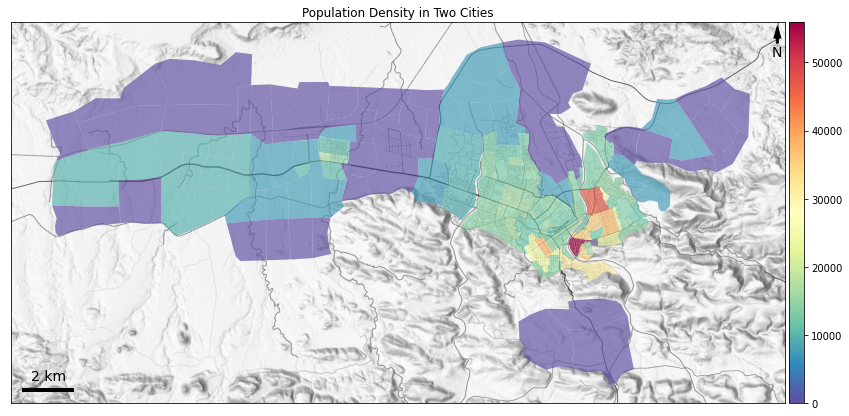

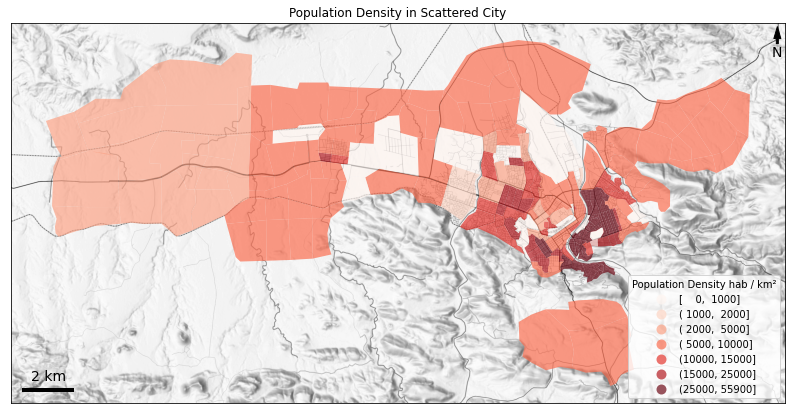

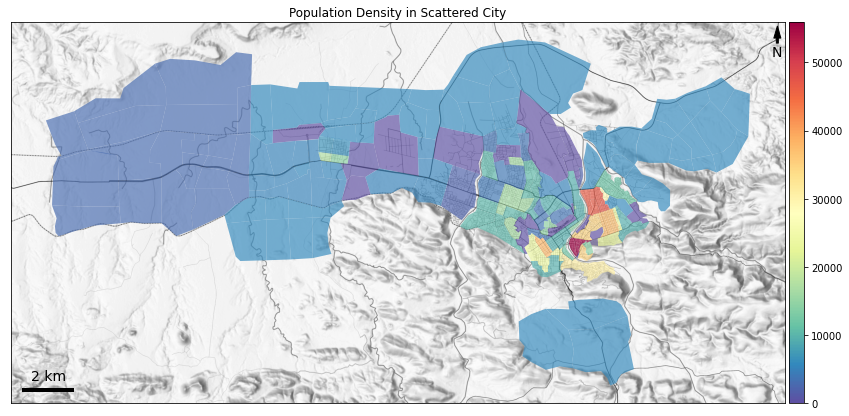

In [18]:
cmap = 'YlOrRd'
cmap = 'RdYlGn_r'
cmap = 'Reds'
if manual:
    for scen in ['2020', 'Polycentric City', 'Two Cities', 'Scattered City']:
        plot = plot_density(zones, column='Population Density ' + scen , cmap=cmap)
        plot.set_title('Population Density in ' + scen)
        plot.get_figure().savefig('../../outputs/population_density_class_' + scen + '.png', bbox_inches='tight')

        plot = plot_density(zones, column='Population Density ' + scen , cmap='Spectral_r', scheme=None)
        plot.set_title('Population Density in ' + scen)
        plot.get_figure().savefig('../../outputs/population_density_' + scen + '.png', bbox_inches='tight')

In [19]:
zones[['kebele_latin', 'latin_name']] = zones[['kebele_latin', 'latin_name']].applymap(format_string)

In [20]:
pa = pd.read_excel('../../inputs/production_attraction_zones.xlsx')
pa['latin_name'] = pa['latin_name'].apply(format_string)

In [21]:
zones.drop(['visit_estim', 'empl_estim'], axis=1, errors='ignore', inplace=True)
zones = pd.merge(zones, pa[['empl_estim', 'visit_estim', 'latin_name']], on='latin_name', how='left')

In [22]:
zones['Jobs 2020'] = zones['empl_estim'].fillna(0)
zones['Visits 2020'] = zones['visit_estim'].fillna(0)

In [23]:
zones['Population 2020'].fillna(0, inplace=True)

In [24]:
job_ratio = zones['Jobs 2020'].sum() / zones['Population 2020'].sum()
visit_ratio = zones['Visits 2020'].sum() / zones['Population 2020'].sum()

In [25]:
for scen in ['2020', 'Polycentric City', 'Two Cities', 'Scattered City']:
    delta = zones['Population %s' % scen] - zones['Population 2020']
    zones['Visits %s' % scen] = zones['Visits 2020'] + delta * visit_ratio
    zones['Jobs %s' % scen] = zones['Jobs 2020'] + delta * visit_ratio
    zones['Job Density %s' % scen] = zones['Jobs %s' % scen] / zones['area']
    zones['Visit Density %s' % scen] = zones['Visits %s' % scen] / zones['area']

In [26]:
to_drop = [
    'Name', 'description', 'timestamp', 'begin', 'end', 'altitudeMode',
    'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon',
    'kebele_amharic', 'amharic_name', 'amharic_code','amharic', 'description',
    'sample',
    
]
zones['zone_index'] = ['zone_' + str(i) for i in zones.index]
zones['id'] = zones['kebele_latin'].fillna(zones['zone_index'])
zones.drop(
    to_drop
    , axis=1
).to_file('../../inputs/zones/zones_with_population_2040.geojson', driver='GeoJSON')

# COMPARISONS

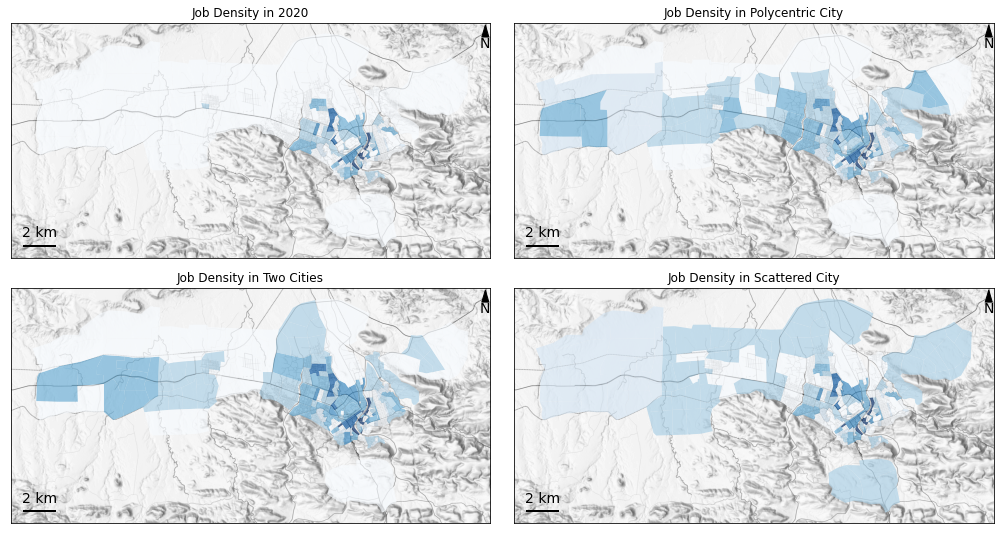

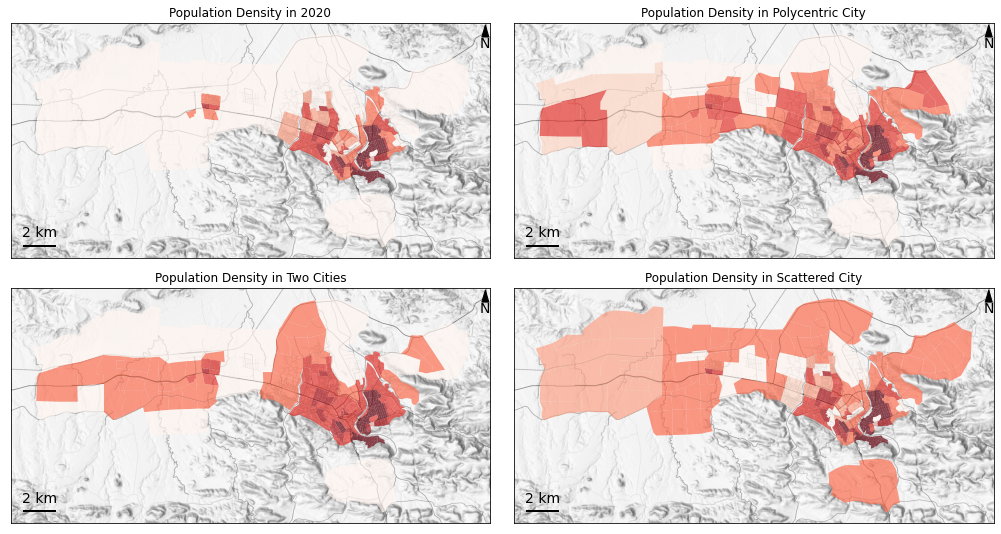

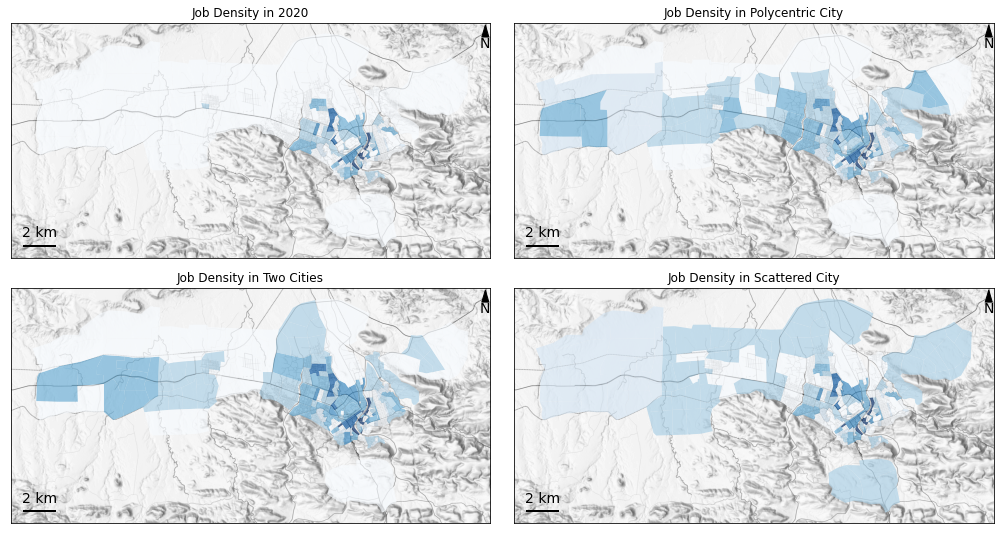

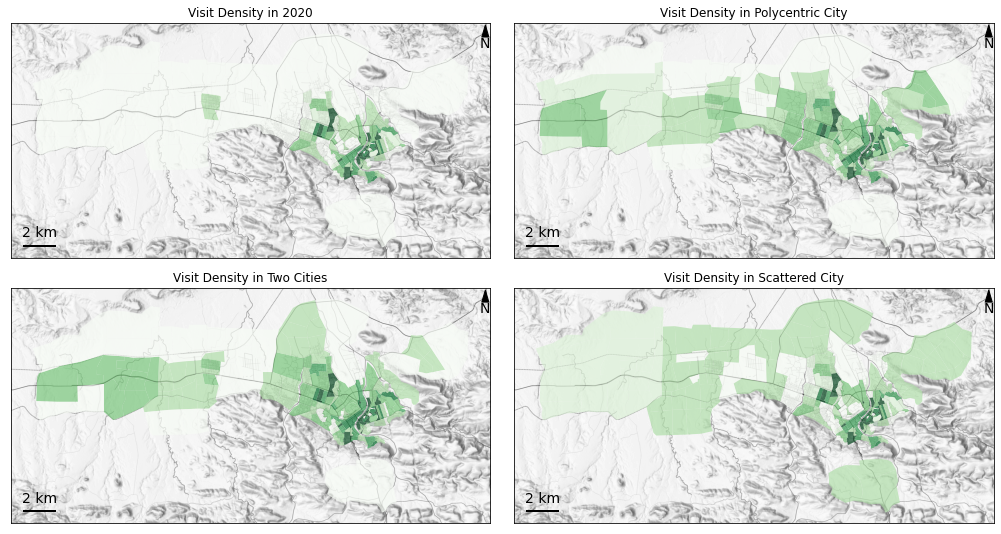

In [28]:
import matplotlib.pyplot as plt
if manual:
    for column, cmap in [('Population', 'Reds'), ('Job', 'Blues'), ('Visit', 'Greens')]:
        rows = columns = 2
        fig, axes = plt.subplots(2, 2, figsize=[25, 25])
        fig.constrained_layout=True
        i = 0
        for scen in ['2020', 'Polycentric City', 'Two Cities', 'Scattered City']:

            plot = plot_density(
                zones, column=column + ' Density ' + scen , cmap=cmap, 
                ax=fig.get_axes()[i], legend=False,
                               )
            plot.set_title(column + ' Density in ' + scen)
            i +=1

        ax = fig.get_axes()[0]
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.set_size_inches(bbox.width*columns, rows*(bbox.height)*1.1)
        fig.subplots_adjust(wspace=0.05, hspace=0.05)

        fig.savefig('../../outputs/%s_density'%column.lower() + '_comparison' + '.png', bbox_inches='tight')